In [1]:
# Cell 1: Setup
"""
Notebook 3: Baseline Model Training
Training ResNet50 and EfficientNet-B4 as baseline models
"""

import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import wandb
from pathlib import Path

from src.models.custom_architectures import build_model
from src.models.losses import get_loss_function
from src.data.dataset import create_data_loaders
from src.training.trainer import Trainer
from src.evaluation.metrics import compute_metrics, plot_confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

/home/usama/anaconda3/envs/analysis/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Device: cuda


In [2]:
# Cell 2: Initialize W&B (optional)
"""
Initialize Weights & Biases for experiment tracking
"""

# Uncomment to use W&B
wandb.init(
    project="knee-oa-classification",
    name="baseline-resnet50",
    config={
        "architecture": "resnet50",
        "epochs": 50,
        "batch_size": 32,
        "learning_rate": 1e-4
    }
)

wandb: Currently logged in as: osama-ikram007 (osama-ikram007-deepchain) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference] in use.
wandb: Use W&B Weave for improved LLM call tracing. Weave is installed but not imported. Add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


In [3]:
# Cell 3: Load Data
"""
Load training, validation, and test datasets
"""

# Configuration
CONFIG = {
    'data_dir': '../data/processed',
    'batch_size': 32,
    'num_workers': 4,
    'image_size': 224
}

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    root_dir=CONFIG['data_dir'],
    batch_size=CONFIG['batch_size'],
    num_workers=CONFIG['num_workers'],
    image_size=CONFIG['image_size'],
    use_weighted_sampling=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Visualize a batch
images, labels = next(iter(train_loader))
print(f"\nBatch shape: {images.shape}")
print(f"Labels: {labels[:10]}")


Train dataset: 4044 samples
Val dataset: 867 samples
Test dataset: 867 samples
Class distribution (train): {0: 1600, 1: 732, 2: 1061, 3: 530, 4: 121}
Train batches: 126
Val batches: 28
Test batches: 28

Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 0, 4, 2, 1, 3, 0, 1, 4, 3])


In [4]:
# Cell 4: Train Baseline ResNet50
"""
Train ResNet50 as baseline model
"""

# Model configuration
resnet_config = {
    'model_type': 'resnet',
    'model_name': 'resnet50',
    'num_classes': 5,
    'pretrained': True,
    'use_ordinal': False
}

# Build model
resnet_model = build_model(resnet_config).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    resnet_model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training configuration
train_config = {
    'epochs': 50,
    'use_amp': True,
    'gradient_clip': 1.0,
    'early_stopping_patience': 10,
    'checkpoint_dir': '../models/checkpoints/resnet50',
    'use_wandb': False
}

# Create trainer
resnet_trainer = Trainer(
    model=resnet_model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    config=train_config
)

# Train
print("\n" + "="*60)
print("Training ResNet50 Baseline")
print("="*60)

resnet_history = resnet_trainer.train(train_loader, val_loader)


Training ResNet50 Baseline

Starting training for 50 epochs
Device: cuda
Mixed Precision: True


Epoch 1/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 19.38it/s, loss=1.1230]



Epoch 1 Summary:
Time: 13.72s | LR: 0.000100
Train - Loss: 1.3598 | Acc: 0.3656
Val   - Loss: 1.1230 | Acc: 0.4775 | MAE: 0.6471
Val   - Precision: 0.5437 | Recall: 0.4775 | F1: 0.4724
✓ Saved best model (val_loss: 1.1230)

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 20.88it/s, loss=1.0117]



Epoch 2 Summary:
Time: 9.77s | LR: 0.000100
Train - Loss: 1.1824 | Acc: 0.4571
Val   - Loss: 1.0117 | Acc: 0.5767 | MAE: 0.5952
Val   - Precision: 0.5747 | Recall: 0.5767 | F1: 0.5309
✓ Saved best model (val_loss: 1.0117)

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 19.86it/s, loss=1.0608]



Epoch 3 Summary:
Time: 10.13s | LR: 0.000099
Train - Loss: 1.1025 | Acc: 0.5082
Val   - Loss: 1.0608 | Acc: 0.5582 | MAE: 0.5421
Val   - Precision: 0.5754 | Recall: 0.5582 | F1: 0.5578

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 20.21it/s, loss=0.9539]



Epoch 4 Summary:
Time: 9.68s | LR: 0.000098
Train - Loss: 1.0528 | Acc: 0.5092
Val   - Loss: 0.9539 | Acc: 0.5352 | MAE: 0.5144
Val   - Precision: 0.6286 | Recall: 0.5352 | F1: 0.5535
✓ Saved best model (val_loss: 0.9539)

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 21.64it/s, loss=0.9238]



Epoch 5 Summary:
Time: 9.60s | LR: 0.000098
Train - Loss: 1.0141 | Acc: 0.5466
Val   - Loss: 0.9238 | Acc: 0.5813 | MAE: 0.4948
Val   - Precision: 0.5903 | Recall: 0.5813 | F1: 0.5845
✓ Saved best model (val_loss: 0.9238)

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 19.36it/s, loss=1.2088]



Epoch 6 Summary:
Time: 10.11s | LR: 0.000096
Train - Loss: 0.9792 | Acc: 0.5665
Val   - Loss: 1.2088 | Acc: 0.4833 | MAE: 0.6886
Val   - Precision: 0.5799 | Recall: 0.4833 | F1: 0.4696

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 20.89it/s, loss=0.9834]



Epoch 7 Summary:
Time: 9.63s | LR: 0.000095
Train - Loss: 0.9522 | Acc: 0.5789
Val   - Loss: 0.9834 | Acc: 0.4937 | MAE: 0.5294
Val   - Precision: 0.6739 | Recall: 0.4937 | F1: 0.5054

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 22.13it/s, loss=0.8323]



Epoch 8 Summary:
Time: 9.71s | LR: 0.000094
Train - Loss: 0.9263 | Acc: 0.5816
Val   - Loss: 0.8323 | Acc: 0.6436 | MAE: 0.4129
Val   - Precision: 0.6562 | Recall: 0.6436 | F1: 0.6363
✓ Saved best model (val_loss: 0.8323)

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 21.81it/s, loss=1.3741]



Epoch 9 Summary:
Time: 9.58s | LR: 0.000092
Train - Loss: 0.9055 | Acc: 0.6029
Val   - Loss: 1.3741 | Acc: 0.4337 | MAE: 0.7382
Val   - Precision: 0.5808 | Recall: 0.4337 | F1: 0.4044

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 20.28it/s, loss=0.8676]



Epoch 10 Summary:
Time: 9.77s | LR: 0.000090
Train - Loss: 0.9034 | Acc: 0.6066
Val   - Loss: 0.8676 | Acc: 0.6205 | MAE: 0.4233
Val   - Precision: 0.6551 | Recall: 0.6205 | F1: 0.6232

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 21.73it/s, loss=0.8735]



Epoch 11 Summary:
Time: 9.83s | LR: 0.000089
Train - Loss: 0.8689 | Acc: 0.6136
Val   - Loss: 0.8735 | Acc: 0.6228 | MAE: 0.4348
Val   - Precision: 0.6575 | Recall: 0.6228 | F1: 0.6330

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 21.06it/s, loss=0.9156]



Epoch 12 Summary:
Time: 9.63s | LR: 0.000086
Train - Loss: 0.8466 | Acc: 0.6252
Val   - Loss: 0.9156 | Acc: 0.5998 | MAE: 0.4383
Val   - Precision: 0.6661 | Recall: 0.5998 | F1: 0.6155

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 20.94it/s, loss=0.8824]



Epoch 13 Summary:
Time: 9.67s | LR: 0.000084
Train - Loss: 0.8974 | Acc: 0.6116
Val   - Loss: 0.8824 | Acc: 0.5882 | MAE: 0.4418
Val   - Precision: 0.6772 | Recall: 0.5882 | F1: 0.6069

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 20.07it/s, loss=0.8456]



Epoch 14 Summary:
Time: 9.96s | LR: 0.000082
Train - Loss: 0.8616 | Acc: 0.6141
Val   - Loss: 0.8456 | Acc: 0.6332 | MAE: 0.4210
Val   - Precision: 0.6333 | Recall: 0.6332 | F1: 0.6311

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 21.36it/s, loss=0.8951]



Epoch 15 Summary:
Time: 9.81s | LR: 0.000079
Train - Loss: 0.8381 | Acc: 0.6277
Val   - Loss: 0.8951 | Acc: 0.5802 | MAE: 0.4510
Val   - Precision: 0.6852 | Recall: 0.5802 | F1: 0.5987

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 21.32it/s, loss=0.9778]



Epoch 16 Summary:
Time: 9.67s | LR: 0.000077
Train - Loss: 0.8336 | Acc: 0.6300
Val   - Loss: 0.9778 | Acc: 0.5306 | MAE: 0.5017
Val   - Precision: 0.6818 | Recall: 0.5306 | F1: 0.5418

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 19.67it/s, loss=0.8401]



Epoch 17 Summary:
Time: 9.93s | LR: 0.000074
Train - Loss: 0.8506 | Acc: 0.6114
Val   - Loss: 0.8401 | Acc: 0.6090 | MAE: 0.4314
Val   - Precision: 0.6582 | Recall: 0.6090 | F1: 0.6239

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 19.75it/s, loss=0.9365]


Epoch 18 Summary:
Time: 9.97s | LR: 0.000071
Train - Loss: 0.8175 | Acc: 0.6421
Val   - Loss: 0.9365 | Acc: 0.5975 | MAE: 0.4556
Val   - Precision: 0.6634 | Recall: 0.5975 | F1: 0.6089

⚠ Early stopping triggered at epoch 18

✓ Loaded best model weights



Evaluating on test set...


Validation: 100%|██████████| 28/28 [00:01<00:00, 19.97it/s, loss=0.8847]



Test Set Results:
Accuracy: 0.6540
MAE: 0.4325
Precision: 0.6693
Recall: 0.6540
F1-Score: 0.6471


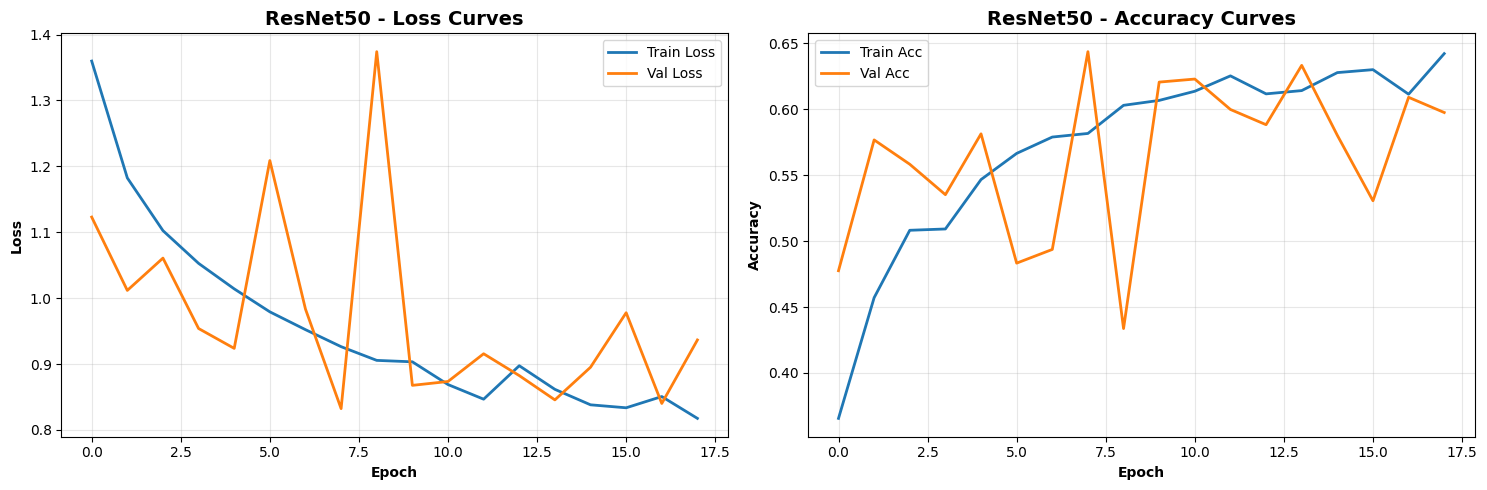

In [5]:
# Cell 5: Evaluate ResNet50
"""
Evaluate ResNet50 on test set
"""

resnet_test_metrics = resnet_trainer.test(test_loader)

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(resnet_history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(resnet_history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss', fontweight='bold')
axes[0].set_title('ResNet50 - Loss Curves', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy curves
axes[1].plot(resnet_history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(resnet_history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Accuracy', fontweight='bold')
axes[1].set_title('ResNet50 - Accuracy Curves', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/resnet50_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Cell 6: Train EfficientNet-B4
"""
Train EfficientNet-B4 model
"""

# Model configuration
efficientnet_config = {
    'model_type': 'efficientnet',
    'model_name': 'efficientnet_b4',
    'num_classes': 5,
    'pretrained': True,
    'use_ordinal': False,
    'use_attention': True
}

# Build model
efficient_model = build_model(efficientnet_config).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    efficient_model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training configuration
train_config['checkpoint_dir'] = '../models/checkpoints/efficientnet_b4'

# Create trainer
efficient_trainer = Trainer(
    model=efficient_model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    config=train_config
)

# Train
print("\n" + "="*60)
print("Training EfficientNet-B4")
print("="*60)

efficient_history = efficient_trainer.train(train_loader, val_loader)


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]


Training EfficientNet-B4

Starting training for 50 epochs
Device: cuda
Mixed Precision: True


Epoch 1/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 13.78it/s, loss=1.5619]



Epoch 1 Summary:
Time: 20.18s | LR: 0.000100
Train - Loss: 1.6025 | Acc: 0.2431
Val   - Loss: 1.5619 | Acc: 0.3979 | MAE: 0.8674
Val   - Precision: 0.4332 | Recall: 0.3979 | F1: 0.3704
✓ Saved best model (val_loss: 1.5619)

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 16.93it/s, loss=1.1553]



Epoch 2 Summary:
Time: 19.61s | LR: 0.000100
Train - Loss: 1.4391 | Acc: 0.3522
Val   - Loss: 1.1553 | Acc: 0.5133 | MAE: 0.6932
Val   - Precision: 0.4545 | Recall: 0.5133 | F1: 0.4298
✓ Saved best model (val_loss: 1.1553)

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 15.72it/s, loss=1.0597]



Epoch 3 Summary:
Time: 25.35s | LR: 0.000099
Train - Loss: 1.1996 | Acc: 0.4318
Val   - Loss: 1.0597 | Acc: 0.4245 | MAE: 0.6205
Val   - Precision: 0.6306 | Recall: 0.4245 | F1: 0.4169
✓ Saved best model (val_loss: 1.0597)

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.18it/s, loss=0.9083]



Epoch 4 Summary:
Time: 26.07s | LR: 0.000098
Train - Loss: 1.1213 | Acc: 0.4705
Val   - Loss: 0.9083 | Acc: 0.6044 | MAE: 0.5052
Val   - Precision: 0.5583 | Recall: 0.6044 | F1: 0.5667
✓ Saved best model (val_loss: 0.9083)

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.42it/s, loss=0.9177]



Epoch 5 Summary:
Time: 24.47s | LR: 0.000098
Train - Loss: 1.0755 | Acc: 0.5084
Val   - Loss: 0.9177 | Acc: 0.5675 | MAE: 0.4787
Val   - Precision: 0.6295 | Recall: 0.5675 | F1: 0.5847

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.97it/s, loss=0.8847]



Epoch 6 Summary:
Time: 23.87s | LR: 0.000096
Train - Loss: 1.0320 | Acc: 0.5283
Val   - Loss: 0.8847 | Acc: 0.5940 | MAE: 0.4752
Val   - Precision: 0.5987 | Recall: 0.5940 | F1: 0.5877
✓ Saved best model (val_loss: 0.8847)

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.26it/s, loss=0.8616]



Epoch 7 Summary:
Time: 24.21s | LR: 0.000095
Train - Loss: 1.0264 | Acc: 0.5223
Val   - Loss: 0.8616 | Acc: 0.6078 | MAE: 0.4556
Val   - Precision: 0.6195 | Recall: 0.6078 | F1: 0.6036
✓ Saved best model (val_loss: 0.8616)

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.31it/s, loss=0.8127]



Epoch 8 Summary:
Time: 25.07s | LR: 0.000094
Train - Loss: 1.0205 | Acc: 0.5216
Val   - Loss: 0.8127 | Acc: 0.6482 | MAE: 0.4210
Val   - Precision: 0.6297 | Recall: 0.6482 | F1: 0.6355
✓ Saved best model (val_loss: 0.8127)

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.61it/s, loss=0.8304]



Epoch 9 Summary:
Time: 24.39s | LR: 0.000092
Train - Loss: 0.9867 | Acc: 0.5528
Val   - Loss: 0.8304 | Acc: 0.6240 | MAE: 0.4452
Val   - Precision: 0.6298 | Recall: 0.6240 | F1: 0.6069

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.70it/s, loss=0.8096]



Epoch 10 Summary:
Time: 25.37s | LR: 0.000090
Train - Loss: 0.9593 | Acc: 0.5563
Val   - Loss: 0.8096 | Acc: 0.6171 | MAE: 0.4245
Val   - Precision: 0.6510 | Recall: 0.6171 | F1: 0.6254
✓ Saved best model (val_loss: 0.8096)

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 16.41it/s, loss=0.8033]



Epoch 11 Summary:
Time: 24.22s | LR: 0.000089
Train - Loss: 0.9485 | Acc: 0.5623
Val   - Loss: 0.8033 | Acc: 0.6263 | MAE: 0.4198
Val   - Precision: 0.6447 | Recall: 0.6263 | F1: 0.6244
✓ Saved best model (val_loss: 0.8033)

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 14.09it/s, loss=0.8354]



Epoch 12 Summary:
Time: 25.68s | LR: 0.000086
Train - Loss: 0.9489 | Acc: 0.5732
Val   - Loss: 0.8354 | Acc: 0.5940 | MAE: 0.4371
Val   - Precision: 0.6778 | Recall: 0.5940 | F1: 0.6120

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.14it/s, loss=0.7956]



Epoch 13 Summary:
Time: 24.78s | LR: 0.000084
Train - Loss: 0.9397 | Acc: 0.5727
Val   - Loss: 0.7956 | Acc: 0.6459 | MAE: 0.3968
Val   - Precision: 0.6697 | Recall: 0.6459 | F1: 0.6551
✓ Saved best model (val_loss: 0.7956)

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.25it/s, loss=0.7851]



Epoch 14 Summary:
Time: 23.23s | LR: 0.000082
Train - Loss: 0.9130 | Acc: 0.5823
Val   - Loss: 0.7851 | Acc: 0.6459 | MAE: 0.3852
Val   - Precision: 0.6815 | Recall: 0.6459 | F1: 0.6594
✓ Saved best model (val_loss: 0.7851)

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.34it/s, loss=0.7596]



Epoch 15 Summary:
Time: 25.44s | LR: 0.000079
Train - Loss: 0.9002 | Acc: 0.5977
Val   - Loss: 0.7596 | Acc: 0.6574 | MAE: 0.3818
Val   - Precision: 0.6690 | Recall: 0.6574 | F1: 0.6627
✓ Saved best model (val_loss: 0.7596)

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.94it/s, loss=0.7675]



Epoch 16 Summary:
Time: 25.56s | LR: 0.000077
Train - Loss: 0.8996 | Acc: 0.5895
Val   - Loss: 0.7675 | Acc: 0.6517 | MAE: 0.3887
Val   - Precision: 0.6611 | Recall: 0.6517 | F1: 0.6556

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.87it/s, loss=0.7971]



Epoch 17 Summary:
Time: 25.58s | LR: 0.000074
Train - Loss: 0.9096 | Acc: 0.5848
Val   - Loss: 0.7971 | Acc: 0.6494 | MAE: 0.3887
Val   - Precision: 0.6784 | Recall: 0.6494 | F1: 0.6596

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.44it/s, loss=0.7738]



Epoch 18 Summary:
Time: 25.40s | LR: 0.000071
Train - Loss: 0.8815 | Acc: 0.6007
Val   - Loss: 0.7738 | Acc: 0.6517 | MAE: 0.3875
Val   - Precision: 0.6759 | Recall: 0.6517 | F1: 0.6604

Epoch 19/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.25it/s, loss=0.8160]



Epoch 19 Summary:
Time: 25.25s | LR: 0.000068
Train - Loss: 0.8536 | Acc: 0.6176
Val   - Loss: 0.8160 | Acc: 0.6413 | MAE: 0.4014
Val   - Precision: 0.6715 | Recall: 0.6413 | F1: 0.6491

Epoch 20/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.09it/s, loss=0.7580]



Epoch 20 Summary:
Time: 25.33s | LR: 0.000065
Train - Loss: 0.8851 | Acc: 0.5997
Val   - Loss: 0.7580 | Acc: 0.6690 | MAE: 0.3725
Val   - Precision: 0.6756 | Recall: 0.6690 | F1: 0.6716
✓ Saved best model (val_loss: 0.7580)

Epoch 21/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.86it/s, loss=0.7779]



Epoch 21 Summary:
Time: 25.25s | LR: 0.000062
Train - Loss: 0.8494 | Acc: 0.6233
Val   - Loss: 0.7779 | Acc: 0.6528 | MAE: 0.3829
Val   - Precision: 0.6894 | Recall: 0.6528 | F1: 0.6649

Epoch 22/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.65it/s, loss=0.7645]



Epoch 22 Summary:
Time: 25.92s | LR: 0.000059
Train - Loss: 0.8570 | Acc: 0.6176
Val   - Loss: 0.7645 | Acc: 0.6597 | MAE: 0.3922
Val   - Precision: 0.6568 | Recall: 0.6597 | F1: 0.6568

Epoch 23/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.67it/s, loss=0.7588]



Epoch 23 Summary:
Time: 25.51s | LR: 0.000056
Train - Loss: 0.8492 | Acc: 0.6188
Val   - Loss: 0.7588 | Acc: 0.6459 | MAE: 0.3899
Val   - Precision: 0.6695 | Recall: 0.6459 | F1: 0.6510

Epoch 24/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.53it/s, loss=0.7626]



Epoch 24 Summary:
Time: 24.66s | LR: 0.000053
Train - Loss: 0.8373 | Acc: 0.6198
Val   - Loss: 0.7626 | Acc: 0.6597 | MAE: 0.3864
Val   - Precision: 0.6638 | Recall: 0.6597 | F1: 0.6601

Epoch 25/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.43it/s, loss=0.7652]



Epoch 25 Summary:
Time: 24.27s | LR: 0.000050
Train - Loss: 0.8346 | Acc: 0.6257
Val   - Loss: 0.7652 | Acc: 0.6448 | MAE: 0.3968
Val   - Precision: 0.6642 | Recall: 0.6448 | F1: 0.6491

Epoch 26/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 14.31it/s, loss=0.7623]



Epoch 26 Summary:
Time: 25.44s | LR: 0.000047
Train - Loss: 0.8262 | Acc: 0.6332
Val   - Loss: 0.7623 | Acc: 0.6505 | MAE: 0.3806
Val   - Precision: 0.6773 | Recall: 0.6505 | F1: 0.6584

Epoch 27/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.76it/s, loss=0.7925]



Epoch 27 Summary:
Time: 25.91s | LR: 0.000044
Train - Loss: 0.8136 | Acc: 0.6357
Val   - Loss: 0.7925 | Acc: 0.6413 | MAE: 0.3991
Val   - Precision: 0.6726 | Recall: 0.6413 | F1: 0.6513

Epoch 28/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.30it/s, loss=0.7659]



Epoch 28 Summary:
Time: 25.02s | LR: 0.000041
Train - Loss: 0.8294 | Acc: 0.6230
Val   - Loss: 0.7659 | Acc: 0.6551 | MAE: 0.3772
Val   - Precision: 0.6804 | Recall: 0.6551 | F1: 0.6642

Epoch 29/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.87it/s, loss=0.7524]



Epoch 29 Summary:
Time: 23.79s | LR: 0.000038
Train - Loss: 0.8186 | Acc: 0.6369
Val   - Loss: 0.7524 | Acc: 0.6597 | MAE: 0.3772
Val   - Precision: 0.6671 | Recall: 0.6597 | F1: 0.6608
✓ Saved best model (val_loss: 0.7524)

Epoch 30/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.73it/s, loss=0.8055]



Epoch 30 Summary:
Time: 24.89s | LR: 0.000035
Train - Loss: 0.8200 | Acc: 0.6312
Val   - Loss: 0.8055 | Acc: 0.6436 | MAE: 0.3910
Val   - Precision: 0.6843 | Recall: 0.6436 | F1: 0.6558

Epoch 31/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.40it/s, loss=0.7713]



Epoch 31 Summary:
Time: 25.14s | LR: 0.000032
Train - Loss: 0.8090 | Acc: 0.6332
Val   - Loss: 0.7713 | Acc: 0.6644 | MAE: 0.3702
Val   - Precision: 0.6885 | Recall: 0.6644 | F1: 0.6730

Epoch 32/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.31it/s, loss=0.7744]



Epoch 32 Summary:
Time: 23.73s | LR: 0.000029
Train - Loss: 0.7983 | Acc: 0.6438
Val   - Loss: 0.7744 | Acc: 0.6551 | MAE: 0.3783
Val   - Precision: 0.6873 | Recall: 0.6551 | F1: 0.6666

Epoch 33/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.26it/s, loss=0.7938]



Epoch 33 Summary:
Time: 25.07s | LR: 0.000026
Train - Loss: 0.7880 | Acc: 0.6486
Val   - Loss: 0.7938 | Acc: 0.6540 | MAE: 0.3795
Val   - Precision: 0.6908 | Recall: 0.6540 | F1: 0.6665

Epoch 34/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.85it/s, loss=0.8208]



Epoch 34 Summary:
Time: 25.38s | LR: 0.000023
Train - Loss: 0.7952 | Acc: 0.6302
Val   - Loss: 0.8208 | Acc: 0.6390 | MAE: 0.3945
Val   - Precision: 0.6902 | Recall: 0.6390 | F1: 0.6533

Epoch 35/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 15.58it/s, loss=0.7794]



Epoch 35 Summary:
Time: 25.05s | LR: 0.000021
Train - Loss: 0.7879 | Acc: 0.6548
Val   - Loss: 0.7794 | Acc: 0.6471 | MAE: 0.3875
Val   - Precision: 0.6863 | Recall: 0.6471 | F1: 0.6604

Epoch 36/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 15.28it/s, loss=0.7795]



Epoch 36 Summary:
Time: 25.39s | LR: 0.000018
Train - Loss: 0.7782 | Acc: 0.6478
Val   - Loss: 0.7795 | Acc: 0.6551 | MAE: 0.3795
Val   - Precision: 0.6957 | Recall: 0.6551 | F1: 0.6690

Epoch 37/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.20it/s, loss=0.7783]



Epoch 37 Summary:
Time: 26.06s | LR: 0.000016
Train - Loss: 0.7722 | Acc: 0.6463
Val   - Loss: 0.7783 | Acc: 0.6471 | MAE: 0.3887
Val   - Precision: 0.6780 | Recall: 0.6471 | F1: 0.6578

Epoch 38/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.17it/s, loss=0.7912]



Epoch 38 Summary:
Time: 25.56s | LR: 0.000014
Train - Loss: 0.7926 | Acc: 0.6453
Val   - Loss: 0.7912 | Acc: 0.6505 | MAE: 0.3841
Val   - Precision: 0.6921 | Recall: 0.6505 | F1: 0.6640

Epoch 39/50
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 11.58it/s, loss=0.7933]



Epoch 39 Summary:
Time: 25.42s | LR: 0.000011
Train - Loss: 0.7755 | Acc: 0.6560
Val   - Loss: 0.7933 | Acc: 0.6482 | MAE: 0.3852
Val   - Precision: 0.6931 | Recall: 0.6482 | F1: 0.6626

⚠ Early stopping triggered at epoch 39

✓ Loaded best model weights



Evaluating on test set...


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.68it/s, loss=0.8110]



Test Set Results:
Accuracy: 0.6736
MAE: 0.3841
Precision: 0.6800
Recall: 0.6736
F1-Score: 0.6737


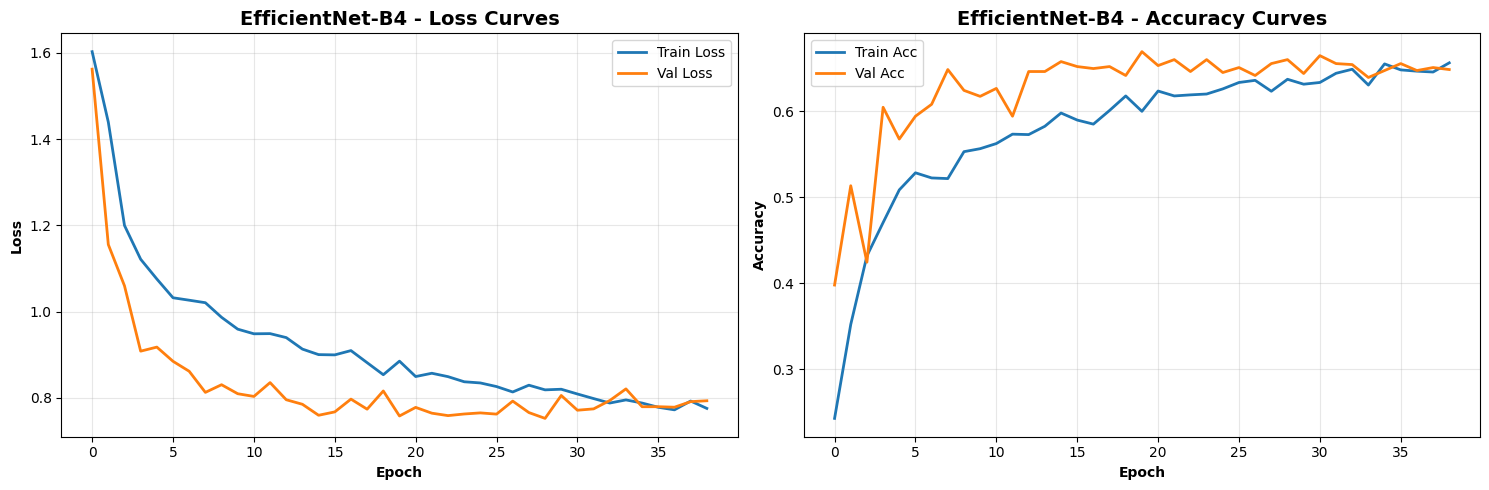

In [7]:
# Cell 7: Evaluate EfficientNet-B4
"""
Evaluate EfficientNet-B4 on test set
"""

efficient_test_metrics = efficient_trainer.test(test_loader)

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(efficient_history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(efficient_history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss', fontweight='bold')
axes[0].set_title('EfficientNet-B4 - Loss Curves', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(efficient_history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(efficient_history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Accuracy', fontweight='bold')
axes[1].set_title('EfficientNet-B4 - Accuracy Curves', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/efficientnet_b4_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

,Model,Test Accuracy,Test MAE,Test F1,Best Val Loss,Best Val Acc
0,ResNet50,0.653979,0.432526,0.647055,0.832312,0.643599
1,EfficientNet-B4,0.673587,0.384083,0.673686,0.752414,0.668973


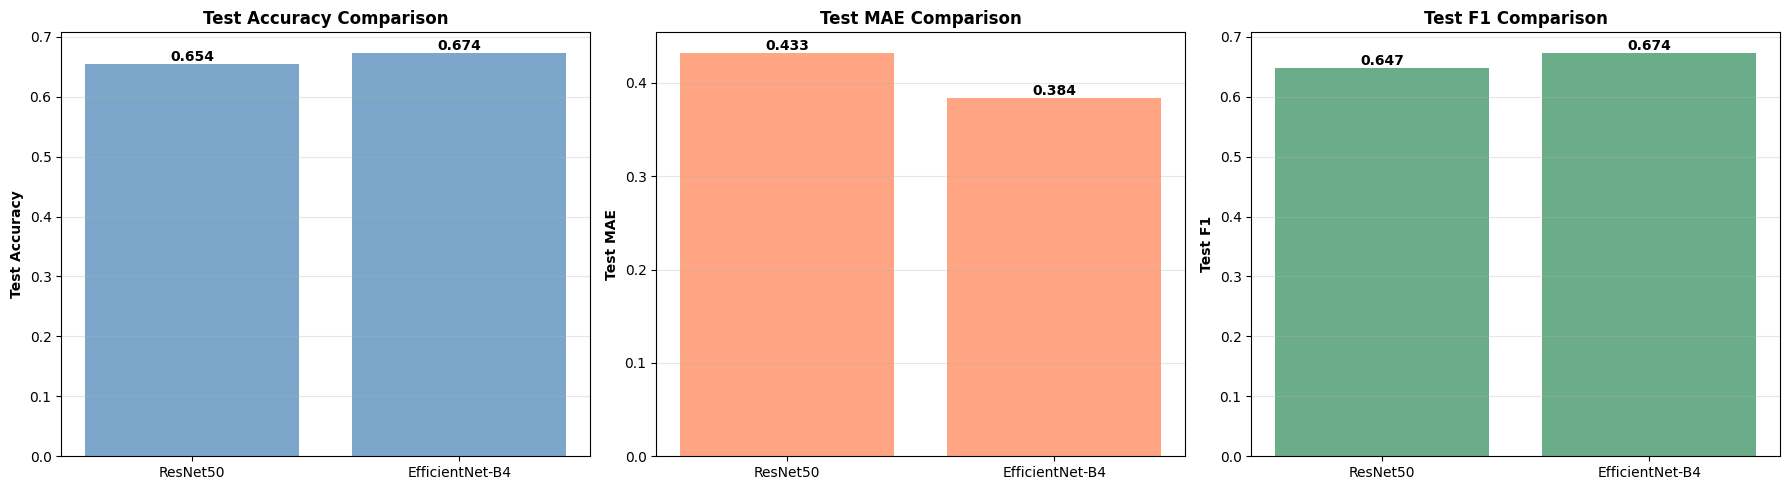

In [8]:
# Cell 8: Compare Baseline Models
"""
Compare ResNet50 vs EfficientNet-B4
"""

# Create comparison DataFrame
comparison_data = {
    'Model': ['ResNet50', 'EfficientNet-B4'],
    'Test Accuracy': [
        resnet_test_metrics['accuracy'],
        efficient_test_metrics['accuracy']
    ],
    'Test MAE': [
        resnet_test_metrics['mae'],
        efficient_test_metrics['mae']
    ],
    'Test F1': [
        resnet_test_metrics['f1'],
        efficient_test_metrics['f1']
    ],
    'Best Val Loss': [
        min(resnet_history['val_loss']),
        min(efficient_history['val_loss'])
    ],
    'Best Val Acc': [
        max(resnet_history['val_acc']),
        max(efficient_history['val_acc'])
    ]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df.style.highlight_max(subset=['Test Accuracy', 'Test F1', 'Best Val Acc'], color='lightgreen')
                           .highlight_min(subset=['Test MAE', 'Best Val Loss'], color='lightgreen'))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Test Accuracy', 'Test MAE', 'Test F1']
colors = ['steelblue', 'coral', 'seagreen']

for idx, metric in enumerate(metrics):
    values = comparison_df[metric].values
    axes[idx].bar(comparison_df['Model'], values, color=colors[idx], alpha=0.7)
    axes[idx].set_ylabel(metric, fontweight='bold')
    axes[idx].set_title(f'{metric} Comparison', fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(values):
        axes[idx].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Predicting:   0%|          | 0/28 [00:00<?, ?it/s]

Predicting:   0%|          | 0/28 [00:00<?, ?it/s]

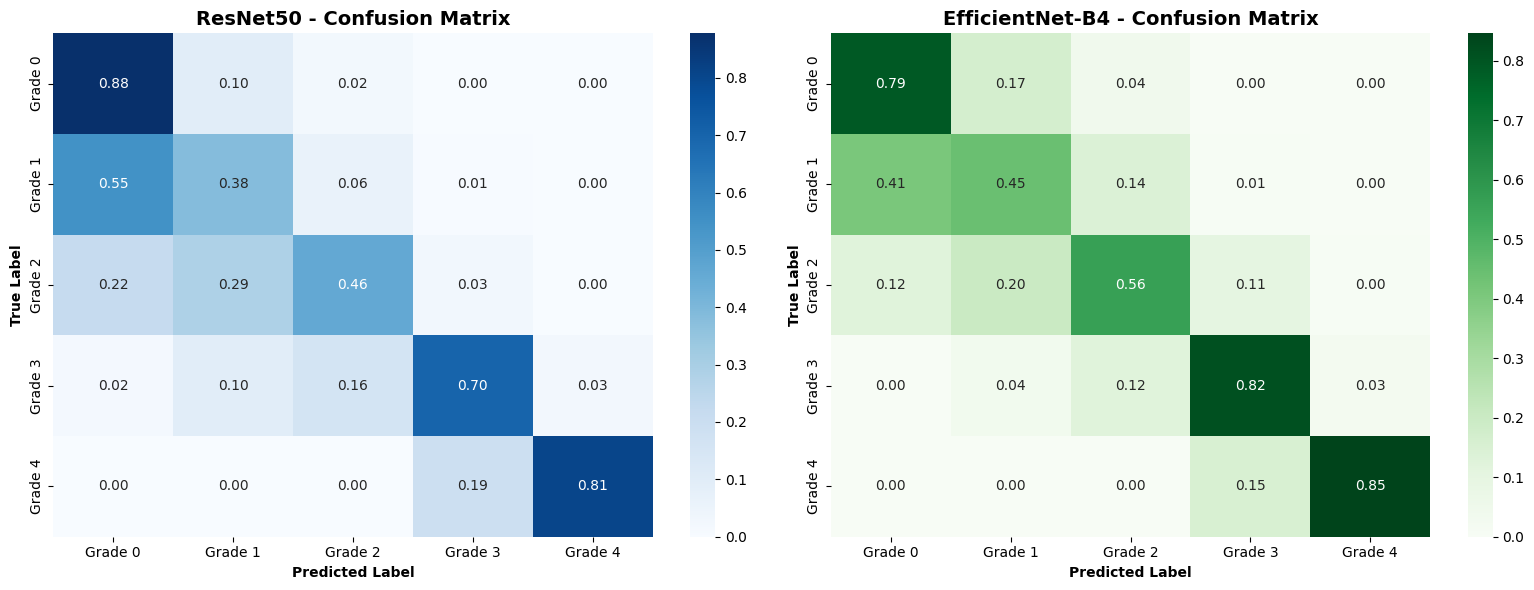

In [9]:
# Cell 9: Confusion Matrices
"""
Plot confusion matrices for both models
"""

# Get predictions for confusion matrix
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Predicting"):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_labels), np.array(all_preds)

# ResNet50 predictions
resnet_labels, resnet_preds = get_predictions(resnet_model, test_loader)

# EfficientNet-B4 predictions
efficient_labels, efficient_preds = get_predictions(efficient_model, test_loader)

# Plot confusion matrices
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_names = ['Grade 0', 'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4']

# ResNet50 CM
cm_resnet = confusion_matrix(resnet_labels, resnet_preds)
cm_resnet_norm = cm_resnet.astype('float') / cm_resnet.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_resnet_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('ResNet50 - Confusion Matrix', fontweight='bold', fontsize=14)
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')

# EfficientNet CM
cm_efficient = confusion_matrix(efficient_labels, efficient_preds)
cm_efficient_norm = cm_efficient.astype('float') / cm_efficient.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_efficient_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('EfficientNet-B4 - Confusion Matrix', fontweight='bold', fontsize=14)
axes[1].set_ylabel('True Label', fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/baseline_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# Cell 10: Save Models
"""
Save trained models
"""
MODEL_SAVED = Path('../models/saved_models/')
if not MODEL_SAVED.exists():
    MODEL_SAVED.mkdir(parents=True)
# Save ResNet50
torch.save({
    'model_state_dict': resnet_model.state_dict(),
    'config': resnet_config,
    'test_metrics': resnet_test_metrics,
    'history': resnet_history
}, '../models/saved_models/resnet50_baseline.pth')

# Save EfficientNet-B4
torch.save({
    'model_state_dict': efficient_model.state_dict(),
    'config': efficientnet_config,
    'test_metrics': efficient_test_metrics,
    'history': efficient_history
}, '../models/saved_models/efficientnet_b4_baseline.pth')

print("✅ Models saved successfully!")
print("\n" + "="*60)
print("BASELINE TRAINING COMPLETE")
print("="*60)
print(f"ResNet50 - Test Acc: {resnet_test_metrics['accuracy']:.4f}, MAE: {resnet_test_metrics['mae']:.4f}")
print(f"EfficientNet-B4 - Test Acc: {efficient_test_metrics['accuracy']:.4f}, MAE: {efficient_test_metrics['mae']:.4f}")
print("="*60)

✅ Models saved successfully!

BASELINE TRAINING COMPLETE
ResNet50 - Test Acc: 0.6540, MAE: 0.4325
EfficientNet-B4 - Test Acc: 0.6736, MAE: 0.3841
